In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pickle as pk

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import RandomBrightness, RandomContrast, RandomCrop, RandomFlip, RandomRotation
from keras.callbacks import EarlyStopping

from functools import partial

IMAGE_SIZE = (256,256,3)
RANDOM_STATE = 42

from cascid.configs.config import DATA_DIR

EXPERIMENT_DIR = DATA_DIR / 'experiments'
MODEL_PATH = DATA_DIR / 'dip' / 'model_resnet_noreg_aug'
MODEL_PATH.mkdir(exist_ok=True, parents=True)

In [31]:
def ResNet(amt_64, amt_128, amt_256, amt_512, augmentation = False):
    # Aurelien Geron, Hands-On Machine Learning with Scikit-Learn, Keras & Tensorflow.
    DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1, padding="SAME", use_bias=False)# , kernel_regularizer=keras.regularizers.l1(l1=0.01)

    class ResidualUnit(keras.layers.Layer):
        def __init__(self, filters, strides=1, activation="relu", **kwargs):
            super().__init__(**kwargs)
            self.activation = keras.activations.get(activation)
            self.main_layers = [
                DefaultConv2D(filters, strides=strides), 
                keras.layers.BatchNormalization(),
                self.activation,
                DefaultConv2D(filters),
                keras.layers.BatchNormalization(),
                keras.layers.SpatialDropout2D(0.3)
            ]
            self.skip_layers = []
            if strides > 1:
                self.skip_layers = [
                    DefaultConv2D(filters, kernel_size=1, strides=strides),
                    keras.layers.BatchNormalization()
                ]
        def call(self, inputs):
            Z = inputs
            for layer in self.main_layers:
                Z = layer(Z)
            skip_Z = inputs
            for layer in self.skip_layers:
                skip_Z = layer(skip_Z)
            return self.activation(Z + skip_Z)

    model = keras.models.Sequential()
    model.add(Input(shape=IMAGE_SIZE))
    if augmentation:
        # model.add(RandomBrightness(factor=(-0.2, 0.2), value_range=(0.0, 1.0), seed=RANDOM_STATE) # Randomly change brightness anywhere from -30% to +30%
        # model.add(RandomContrast(factor=0.5, seed=RANDOM_STATE)) # Randomly change contrast anywhere from -30% to +30%
        model.add(RandomFlip(mode="horizontal_and_vertical", seed=RANDOM_STATE)), # Randomly flip images either horizontally, vertically or both
        model.add(RandomRotation(factor=(-0.2, 0.2), fill_mode="nearest", interpolation="bilinear", seed=RANDOM_STATE)) # Randomly rotate anywhere from -30% * 2PI to +30% * 2PI, filling gaps by using 'nearest' strategy)
        model.add(DefaultConv2D(64, kernel_size=7, strides=2))
    else:
        model.add(DefaultConv2D(64, kernel_size=7, strides=2))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
    prev_filters = 64
    for filters in [64] * amt_64 + [128] * amt_128 + [256] * amt_256 + [512] * amt_512:
        strides = 1 if filters == prev_filters else 2
        model.add(ResidualUnit(filters, strides=strides))
        prev_filters = filters
    model.add(keras.layers.GlobalAvgPool2D())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(2, activation="softmax"))
    return model

def dump_results(model, history, path):
    model.save(path)

    with open(path / "history.pkl", "wb") as fl:
        pk.dump(history, fl)


In [3]:
# 'resnet18': (2, 2, 2, 2)
# 'resnet34': (3, 4, 6, 3)

model = ResNet(3,4,6,3, augmentation=True)

2022-10-13 14:53:30.955178: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:53:30.963110: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:53:30.963804: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:53:30.964757: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

o
2022-10-13 14:53:30.965903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:53:30.966479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:53:31.978042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:53:31.978782: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:53:31.979353: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from

In [4]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['acc', keras.metrics.AUC()]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 256, 256, 3)      0         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      9408      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0

In [5]:
from cascid.datasets.pad_ufes import database, images

df = database.get_df()
df.head(5).transpose()

,0,1,2,3,4
patient_id,PAT_1516,PAT_46,PAT_1545,PAT_1989,PAT_684
lesion_id,1765,881,1867,4061,1302
smoke,NaN,False,NaN,NaN,False
drink,NaN,False,NaN,NaN,True
background_father,NaN,POMERANIA,NaN,NaN,POMERANIA
background_mother,NaN,POMERANIA,NaN,NaN,POMERANIA
age,8,55,77,75,79
pesticide,NaN,False,NaN,NaN,False
gender,NaN,FEMALE,NaN,NaN,MALE
skin_cancer_history,NaN,True,NaN,NaN,True


In [6]:
im = df['img_id']
im

0       PAT_1516_1765_530.png
1          PAT_46_881_939.png
2       PAT_1545_1867_547.png
3       PAT_1989_4061_934.png
4        PAT_684_1302_588.png
                ...          
2293    PAT_1708_3156_175.png
2294       PAT_46_880_140.png
2295    PAT_1343_1217_404.png
2296      PAT_326_690_823.png
2297    PAT_1714_3189_989.png
Name: img_id, Length: 2298, dtype: object

In [7]:
from cascid.image.apply_preprocessing import remove_hair

remove_hair(im.to_list())

Beginning transformations, this may take a while...
Finished transformations after 0h00min0.04s


In [8]:
x = df['img_id'].apply(lambda x: images.get_hairless_image(x, IMAGE_SIZE[:2])).to_numpy()
x.shape

(2298,)

In [9]:
x = np.array([x[i] for i in range(len(x))])
x.shape

(2298, 256, 256, 3)

In [10]:
OHE = OneHotEncoder(sparse=False)
y=df['diagnostic'].apply(lambda x: "Cancer" if x in ['MEL', 'SCC', 'BCC'] else "Not").to_numpy().reshape(-1,1)
y = OHE.fit_transform(y)
y.shape

(2298, 2)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
print("x_train shape: {0}".format(x_train.shape))
print("x_test shape: {0}".format(x_test.shape))
print("y_train shape: {0}".format(y_train.shape))
print("y_test shape: {0}".format(y_test.shape))

x_train shape: (2068, 256, 256, 3)
x_test shape: (230, 256, 256, 3)
y_train shape: (2068, 2)
y_test shape: (230, 2)


In [19]:
history = model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=128,
    validation_split=0.15
)

Epoch 1/100
14/14 [==============================] - 9s 677ms/step - loss: 0.4109 - acc: 0.8002 - auc: 0.8924 - val_loss: 0.5585 - val_acc: 0.7299 - val_auc: 0.7939
Epoch 2/100
14/14 [==============================] - 10s 684ms/step - loss: 0.4012 - acc: 0.8173 - auc: 0.8994 - val_loss: 0.7991 - val_acc: 0.7235 - val_auc: 0.7714
Epoch 3/100
14/14 [==============================] - 9s 669ms/step - loss: 0.3979 - acc: 0.8116 - auc: 0.8997 - val_loss: 0.7664 - val_acc: 0.7395 - val_auc: 0.7939
Epoch 4/100
14/14 [==============================] - 9s 659ms/step - loss: 0.3962 - acc: 0.8184 - auc: 0.9009 - val_loss: 0.6160 - val_acc: 0.7170 - val_auc: 0.8122
Epoch 5/100
14/14 [==============================] - 9s 662ms/step - loss: 0.3928 - acc: 0.8190 - auc: 0.9029 - val_loss: 0.5745 - val_acc: 0.7395 - val_auc: 0.8092
Epoch 6/100
14/14 [==============================] - 9s 667ms/step - loss: 0.4173 - acc: 0.8116 - auc: 0.8913 - val_loss: 0.5843 - val_acc: 0.6977 - val_auc: 0.7762
Epoch 7/1

In [28]:
# history = history.history
train_loss = history['acc']
val_loss = history['val_acc']

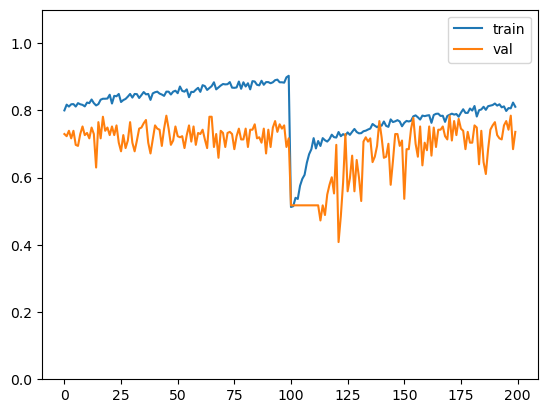

In [29]:
x = range(len(train_loss))
plt.plot(x, train_loss, label='train')
plt.plot(x, val_loss, label='val')
plt.ylim((0, 1.1))
plt.legend()
plt.show();

In [27]:
# Merge history from multiple steps
# with open(MODEL_PATH / 'history.pkl', 'rb') as fl:
#     h = pk.load(fl)

# for k in h.keys():
#     history[k] = h[k] + history[k]

In [32]:
dump_results(model, history, MODEL_PATH)

INFO:tensorflow:Assets written to: /home/dell/.cascid_data/dip/model_resnet_noreg_aug/assets


INFO:tensorflow:Assets written to: /home/dell/.cascid_data/dip/model_resnet_noreg_aug/assets
